<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

# Imports

In [1]:
import pandas as pd
import numpy as np
import operator
import sys
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

# Helper Functions

In [2]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [3]:
# Companies description
desc_df = pd.read_csv('../notebooks/content/constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('../notebooks/content/stocks_data/all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


# Preprocess

In [9]:
stocks_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [48]:
tester = stocks_df.groupby("Name", as_index=False)
stocks_df3 = tester.mean()
stocks_df3

,Name,open,high,low,close,volume
0,A,49.187863,49.600059,48.782026,49.202025,2.338039e+06
1,AAL,38.390495,38.955554,37.825605,38.393252,9.390321e+06
2,AAP,132.439631,133.818297,131.036025,132.433463,1.078043e+06
3,AAPL,109.055429,109.951118,108.141589,109.066698,5.404790e+07
4,ABBV,60.802801,61.474133,60.177275,60.864440,7.870683e+06
...,...,...,...,...,...,...
500,XYL,41.415473,41.763885,41.076026,41.434095,1.183141e+06
501,YUM,75.422099,76.027123,74.844914,75.451009,3.209032e+06
502,ZBH,105.542014,106.419854,104.698038,105.606291,1.297144e+06
503,ZION,32.161477,32.509290,31.802241,32.171790,2.621178e+06


In [47]:
stocks_df2.columns

Index(['open', 'high', 'low', 'close', 'volume', 'change'], dtype='object')

In [49]:
tester = stocks_df.groupby("Name", as_index=False)
stocks_df2 = tester.mean()
stocks_df2

,Name,open,high,low,close,volume
0,A,49.187863,49.600059,48.782026,49.202025,2.338039e+06
1,AAL,38.390495,38.955554,37.825605,38.393252,9.390321e+06
2,AAP,132.439631,133.818297,131.036025,132.433463,1.078043e+06
3,AAPL,109.055429,109.951118,108.141589,109.066698,5.404790e+07
4,ABBV,60.802801,61.474133,60.177275,60.864440,7.870683e+06
...,...,...,...,...,...,...
500,XYL,41.415473,41.763885,41.076026,41.434095,1.183141e+06
501,YUM,75.422099,76.027123,74.844914,75.451009,3.209032e+06
502,ZBH,105.542014,106.419854,104.698038,105.606291,1.297144e+06
503,ZION,32.161477,32.509290,31.802241,32.171790,2.621178e+06


In [ ]:
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
    
stocks_df2 = stocks_df
stocks_df2["change"] = 0.0
for symbol, op, cl in stocks_df2[['Name','open', 'close']].values:
    
    

In [50]:
stocks_df2[['Name','open', 'close']].values

array([['A', 49.187863383637826, 49.20202541699773],
       ['AAL', 38.39049547259726, 38.39325226370134],
       ['AAP', 132.4396305798252, 132.43346306592537],
       ...,
       ['ZBH', 105.54201350277987, 105.60629070691019],
       ['ZION', 32.161477124702174, 32.171790309769676],
       ['ZTS', 45.09138895949164, 45.09864813343923]], dtype=object)

In [ ]:
grouped = stocks_df.groupby("Name", as_index=False)
stocks_df2 = grouped.mean()
stocks_df2["change"] = 0.0
for symbol, op, cl, in stocks_df2[['Name','open', 'close']].values:
    index = stocks_df2[stocks_df2.Name == symbol].index[0]
    stocks_df2["change"][index] = (cl - op)/op
stocks_df2

In [ ]:
stocks_df2.loc["A"]

In [ ]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all it's stocks
dates_dictionary = {date:{} for date in dates}

In [ ]:
dates_dictionary

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [ ]:
len(companies_sector)

In [ ]:
dates_dictionary

In [ ]:
print(stocks_w2v_data[200])

In [ ]:
stocks_df.head(5)

In [ ]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[1258])

In [52]:
grouped = stocks_df.groupby("Name", as_index=False)
stocks_df2 = grouped.mean()
stocks_df2["change"] = 0.0
for symbol, op, cl, in stocks_df2[['Name','open', 'close']].values:
    index = stocks_df2[stocks_df2.Name == symbol].index[0]
    stocks_df2["change"][index] = (cl - op)/op
stocks_df2

<ipython-input-52-72c7928853a0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_df2["change"][index] = (cl - op)/op


,Name,open,high,low,close,volume,change
0,A,49.187863,49.600059,48.782026,49.202025,2.338039e+06,0.000288
1,AAL,38.390495,38.955554,37.825605,38.393252,9.390321e+06,0.000072
2,AAP,132.439631,133.818297,131.036025,132.433463,1.078043e+06,-0.000047
3,AAPL,109.055429,109.951118,108.141589,109.066698,5.404790e+07,0.000103
4,ABBV,60.802801,61.474133,60.177275,60.864440,7.870683e+06,0.001014
...,...,...,...,...,...,...,...
500,XYL,41.415473,41.763885,41.076026,41.434095,1.183141e+06,0.000450
501,YUM,75.422099,76.027123,74.844914,75.451009,3.209032e+06,0.000383
502,ZBH,105.542014,106.419854,104.698038,105.606291,1.297144e+06,0.000609
503,ZION,32.161477,32.509290,31.802241,32.171790,2.621178e+06,0.000321


In [36]:
stocks_df2.loc["A"]

open      4.918786e+01
high      4.960006e+01
low       4.878203e+01
close     4.920203e+01
volume    2.338039e+06
change    0.000000e+00
Name: A, dtype: float64

In [16]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all it's stocks
dates_dictionary = {date:{} for date in dates}

In [17]:
dates_dictionary

{'2013-02-08': {},
 '2013-02-11': {},
 '2013-02-12': {},
 '2013-02-13': {},
 '2013-02-14': {},
 '2013-02-15': {},
 '2013-02-19': {},
 '2013-02-20': {},
 '2013-02-21': {},
 '2013-02-22': {},
 '2013-02-25': {},
 '2013-02-26': {},
 '2013-02-27': {},
 '2013-02-28': {},
 '2013-03-01': {},
 '2013-03-04': {},
 '2013-03-05': {},
 '2013-03-06': {},
 '2013-03-07': {},
 '2013-03-08': {},
 '2013-03-11': {},
 '2013-03-12': {},
 '2013-03-13': {},
 '2013-03-14': {},
 '2013-03-15': {},
 '2013-03-18': {},
 '2013-03-19': {},
 '2013-03-20': {},
 '2013-03-21': {},
 '2013-03-22': {},
 '2013-03-25': {},
 '2013-03-26': {},
 '2013-03-27': {},
 '2013-03-28': {},
 '2013-04-01': {},
 '2013-04-02': {},
 '2013-04-03': {},
 '2013-04-04': {},
 '2013-04-05': {},
 '2013-04-08': {},
 '2013-04-09': {},
 '2013-04-10': {},
 '2013-04-11': {},
 '2013-04-12': {},
 '2013-04-15': {},
 '2013-04-16': {},
 '2013-04-17': {},
 '2013-04-18': {},
 '2013-04-19': {},
 '2013-04-22': {},
 '2013-04-23': {},
 '2013-04-24': {},
 '2013-04-25

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [151]:
len(companies_sector)

505

In [152]:
dates_dictionary

{'2013-02-08': {},
 '2013-02-11': {},
 '2013-02-12': {},
 '2013-02-13': {},
 '2013-02-14': {},
 '2013-02-15': {},
 '2013-02-19': {},
 '2013-02-20': {},
 '2013-02-21': {},
 '2013-02-22': {},
 '2013-02-25': {},
 '2013-02-26': {},
 '2013-02-27': {},
 '2013-02-28': {},
 '2013-03-01': {},
 '2013-03-04': {},
 '2013-03-05': {},
 '2013-03-06': {},
 '2013-03-07': {},
 '2013-03-08': {},
 '2013-03-11': {},
 '2013-03-12': {},
 '2013-03-13': {},
 '2013-03-14': {},
 '2013-03-15': {},
 '2013-03-18': {},
 '2013-03-19': {},
 '2013-03-20': {},
 '2013-03-21': {},
 '2013-03-22': {},
 '2013-03-25': {},
 '2013-03-26': {},
 '2013-03-27': {},
 '2013-03-28': {},
 '2013-04-01': {},
 '2013-04-02': {},
 '2013-04-03': {},
 '2013-04-04': {},
 '2013-04-05': {},
 '2013-04-08': {},
 '2013-04-09': {},
 '2013-04-10': {},
 '2013-04-11': {},
 '2013-04-12': {},
 '2013-04-15': {},
 '2013-04-16': {},
 '2013-04-17': {},
 '2013-04-18': {},
 '2013-04-19': {},
 '2013-04-22': {},
 '2013-04-23': {},
 '2013-04-24': {},
 '2013-04-25

In [7]:
print(stocks_w2v_data[200])

['CTSH', 'INTC', 'EIX', 'DHI', 'IDXX', 'HCP', 'FL', 'FB', 'FBHS', 'HCN', 'GM', 'NBL', 'EA', 'LEN', 'INTU', 'NRG', 'DLR', 'IBM', 'CMG', 'AMD', 'MRO', 'PHM', 'BAX', 'NVDA', 'ATVI', 'EXPE', 'EXC', 'GPN', 'VTR', 'SBAC', 'LB', 'PAYX', 'CTL', 'NEM', 'GGP', 'PWR', 'NWS', 'SPG', 'SYMC', 'ZTS', 'AKAM', 'RRC', 'MGM', 'HP', 'ACN', 'PKG', 'SEE', 'NUE', 'ESS', 'MAS', 'MLM', 'PKI', 'APC', 'HST', 'MHK', 'FDX', 'DVN', 'TIF', 'WYNN', 'FTI', 'DVA', 'LOW', 'UHS', 'HRB', 'BXP', 'F', 'UDR', 'FE', 'AIV', 'AVB', 'BLL', 'EXPD', 'SNI', 'KSU', 'O', 'HD', 'TEL', 'IRM', 'VRTX', 'VIAB', 'REG', 'MET', 'CHD', 'COF', 'WAT', 'AMT', 'A', 'MTD', 'CAH', 'GPS', 'SBUX', 'FRT', 'DPS', 'EQT', 'KIM', 'TMO', 'KLAC', 'ETR', 'BAC', 'TJX', 'VAR', 'NWSA', 'ED', 'NOV', 'MAT', 'SIG', 'EQR', 'FFIV', 'CCI', 'MAA', 'SO', 'EMN', 'CXO', 'NFLX', 'FCX', 'BK', 'HOLX', 'PNW', 'UAA', 'MAR', 'FISV', 'TWX', 'D', 'DRE', 'IQV', 'FOXA', 'JEC', 'VZ', 'IFF', 'BWA', 'GOOGL', 'XLNX', 'ZBH', 'KORS', 'CLX', 'AMAT', 'TRIP', 'SRE', 'XEC', 'STX', 'ADS', 'A

In [25]:
stocks_df.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [18]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[1258])

['CHK', 'MCHP', 'NRG', 'KORS', 'RRC', 'MRO', 'AKAM', 'COG', 'DVN', 'HES', 'APA', 'EQT', 'NBL', 'NFX', 'FTI', 'APC', 'NOV', 'DISCK', 'DISCA', 'PXD', 'GOOG', 'IT', 'PX', 'MU', 'DIS', 'MPC', 'FCX', 'ALGN', 'VIAB', 'GOOGL', 'BDX', 'LYB', 'TXN', 'SCG', 'EOG', 'LRCX', 'AMAT', 'O', 'PVH', 'XEC', 'CLX', 'OXY', 'AMZN', 'ANDV', 'AAPL', 'FB', 'HAL', 'FOXA', 'BHGE', 'CHD', 'SWKS', 'XLNX', 'SLB', 'FOX', 'HSY', 'AAP', 'XOM', 'BLL', 'TAP', 'ISRG', 'AZO', 'SYMC', 'HP', 'CVX', 'CMI', 'SYY', 'KLAC', 'ADI', 'PH', 'PWR', 'NEM', 'EL', 'KMB', 'IDXX', 'GIS', 'K', 'PCAR', 'BAX', 'EQR', 'LLY', 'AWK', 'CXO', 'PSX', 'REGN', 'WU', 'PKG', 'SNPS', 'SWK', 'DHR', 'ES', 'AES', 'SBUX', 'VAR', 'ADSK', 'PDCO', 'CTXS', 'FMC', 'UNP', 'INCY', 'KIM', 'PM', 'NEE', 'HCN', 'MAA', 'AVB', 'MSFT', 'CHTR', 'FBHS', 'WHR', 'NWSA', 'DLTR', 'BIIB', 'EQIX', 'VRTX', 'AIV', 'EXC', 'CBS', 'APD', 'AMD', 'PCG', 'ETN', 'PLD', 'QRVO', 'ETFC', 'INFO', 'BRK.B', 'EBAY', 'ADBE', 'RMD', 'NI', 'NUE', 'ALB', 'ANSS', 'CSX', 'ORLY', 'COP', 'FRT', 'COST

In [8]:
len(stocks_w2v_data)

1259

# Train Word Embeddings

In [156]:
def hash(astring):
   return ord(astring[0])

In [13]:
stocks_ordered = [[value[0] for value in dates_dictionary[date]] for date in dates]
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    fig, ax = pyplot.subplots(figsize=(20, 15)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=sns.diverging_palette(230, 30, n=9),
        ax=ax,
        annot_kws={"fontsize":20}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    pyplot.ylabel('Actual', fontsize = 20)
    pyplot.xlabel('Predicted', fontsize = 20)
    ax.set_title('Confusion Matrix', fontsize = 40, y = -.02)
    ax.set_xticklabels(class_names, fontsize=20, rotation=90)
    ax.set_yticklabels(class_names, rotation=0, fontsize = 20)
    b, t = pyplot.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    pyplot.ylim(b, t) # update the ylim(bottom, top) values
    pyplot.show() # ta-da! '''

this is j: 4
Word2Vec(vocab=505, size=4, alpha=0.025)
['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE

<ipython-input-17-1d699d2f6d41>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


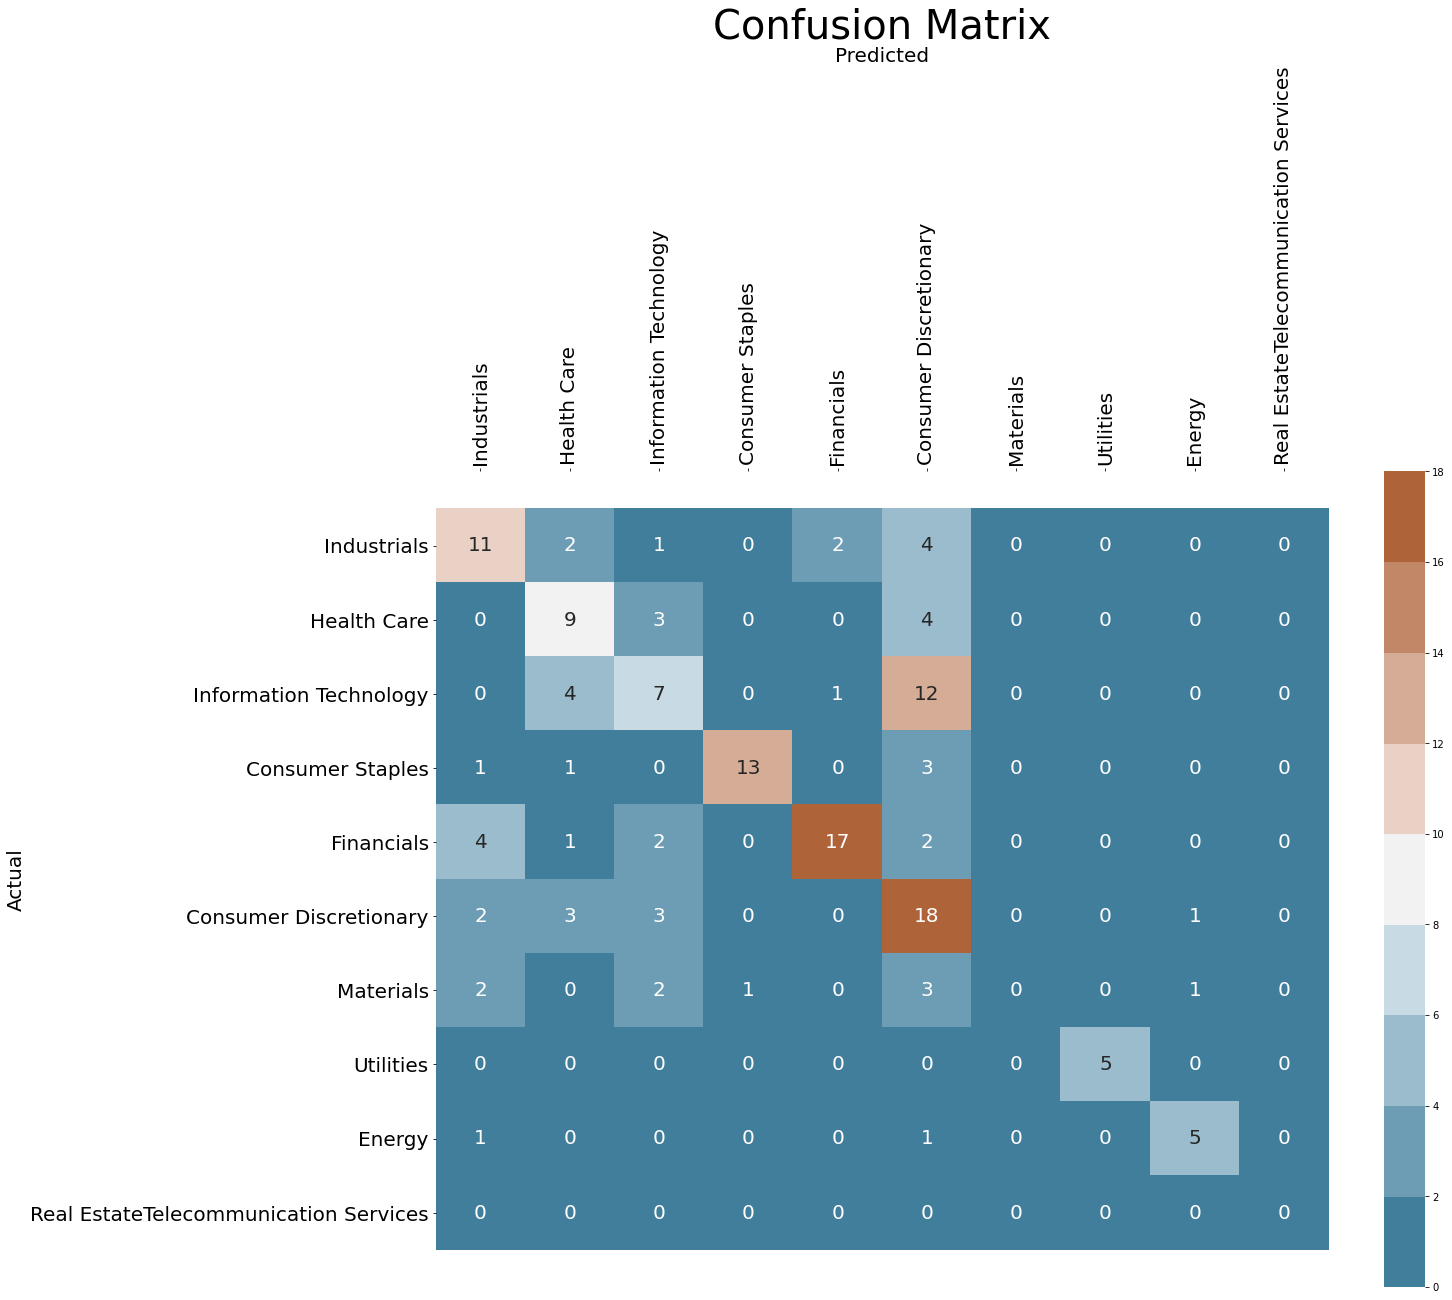

In [17]:
# train model
featureNumber = 15
labels = ['Industrials' ,'Health Care' ,'Information Technology' ,'Consumer Staples','Financials','Consumer Discretionary'
                      , 'Materials', 'Utilities','Energy', 'Real Estate'
                     'Telecommunication Services']

for j in range(4,5):
    print("this is j: " + str(j))
    model = Word2Vec(stocks_w2v_data, min_count=1, size=j)
    print(model)
    words = list(model.wv.vocab)
    print(words)
    X = model[model.wv.vocab]
    Y = list()
    for word in words:
        Y.append(companies_sector[word])

    train, test, train_labels, test_labels = train_test_split(X, Y, test_size=0.33, random_state=42)
    classifiers = []
    # Initialize our classifiers
    #model1 = GaussianNB()
    #classifiers.append(model1)
    model2 = svm.SVC(gamma = 1, C = 1)
    classifiers.append(model2)
    #model3 = tree.DecisionTreeClassifier()
    #classifiers.append(model3)
    #model4 = RandomForestClassifier()
    #classifiers.append(model4)
    # Train our classifier
    for clf in classifiers:
        clf.fit(train, train_labels)
        y_pred= clf.predict(test)
        acc = accuracy_score(test_labels, y_pred)
        print("Accuracy is ", acc)
        plot_cm(test_labels,y_pred,labels)
    #classifier = gnb.fit(train, train_labels)
    #preds = gnb.predict(test)
    #print(accuracy_score(test_labels, preds))

np.set_printoptions(threshold=sys.maxsize)

In [19]:
# Save Stoct2vec Vectors
binary_vectors = 'stoack2vec_Keyed_Binary.bin'
text_vectors = 'stoack2vec_Keyed_Text.vec'
stoack2vecKeyedBinary = model.wv.save_word2vec_format(fname=binary_vectors, binary=True)
stoack2vecKeyedText = model.wv.save_word2vec_format(fname=text_vectors, binary=False)

In [9]:
model.wv['TPR']

array([ 0.2112706 ,  0.1890384 , -0.18673316,  0.4230087 , -0.34580413,
       -0.8067694 ,  0.53886294,  0.5873677 , -0.5575242 , -0.18755734],
      dtype=float32)

In [105]:
#binary_vectors = 'stoack2vec_Keyed_Binary2.bin'
text_vectors = 'wordvectors.kv'
#path = get_tmpfile("wordvectors.kv")
#stoack2vecKeyedBinary = model.wv.save(path)
model.wv.save(text_vectors)

In [136]:
X.shape

(505, 10)

In [107]:
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)

[2.8724933  1.4670901  0.5745572  0.33272272 0.15889281 0.02129036
 0.01698972]
Matrix W:
 [[-0.07785168 -0.09055352]
 [ 0.19861968 -0.69616973]
 [-0.23933938  0.3124696 ]
 [-0.13026708 -0.18914756]
 [-0.34980193  0.00589452]
 [ 0.53783625 -0.2775    ]
 [ 0.1952315  -0.09037597]]


In [10]:
words = list(model.wv.vocab)
X = model[model.wv.vocab]

<ipython-input-10-fe201196f604>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


<ipython-input-137-1edc415c4da8>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


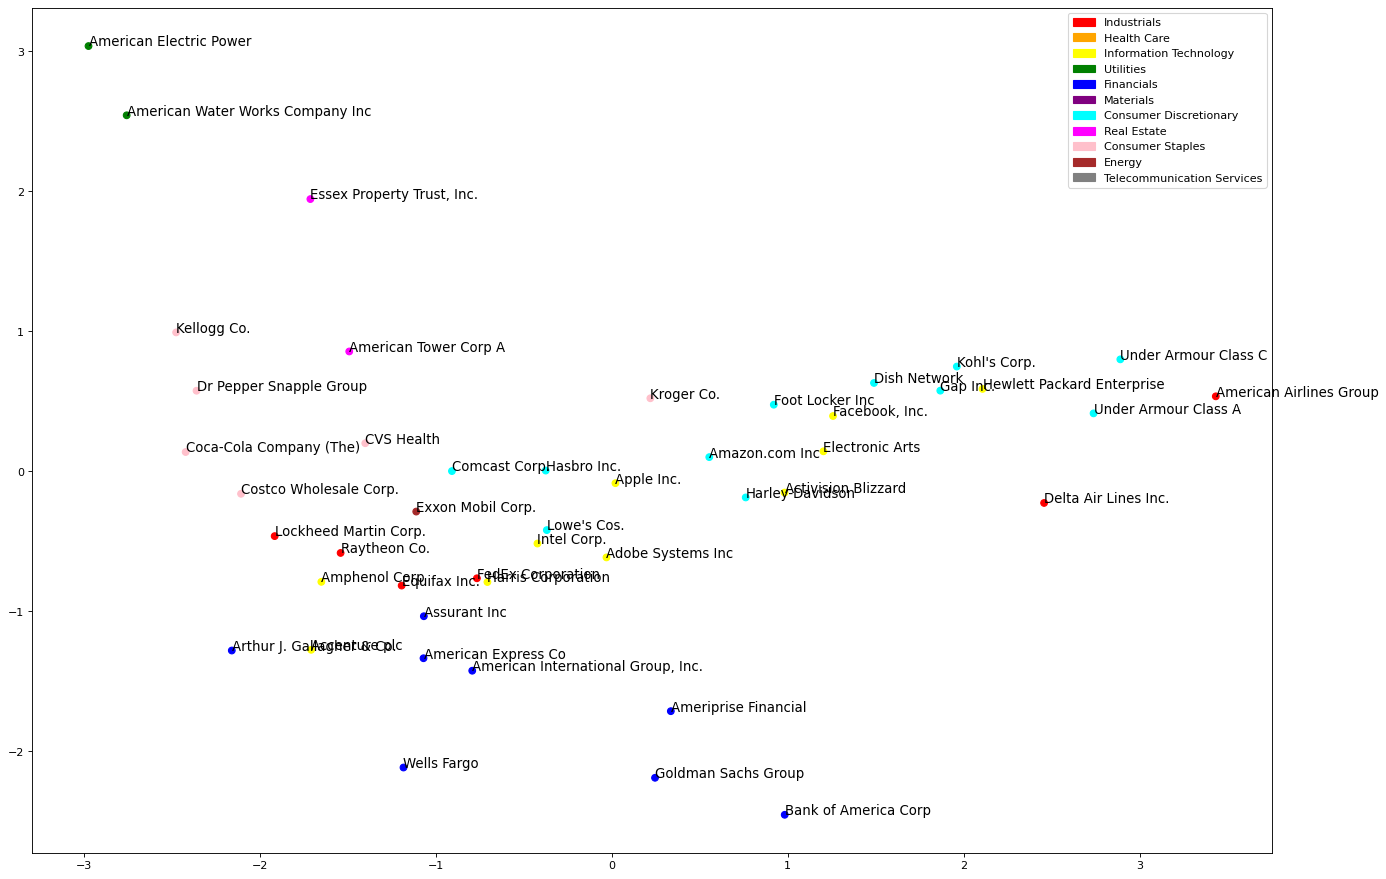

"\npca.fit(X)\neigen_vecs = pca.components_\neigen_vals = pca.explained_variance_\nprint(eigen_vals)\n# Make a list of (eigenvalue, eigenvector) tuples\neigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neigen_pairs.sort(key=lambda k: k[0], reverse=True)\n\nw = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))\n\nprint('Matrix W:\n', w)\n"

In [137]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=4)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

In [139]:
# access vector for one word
print(model['AAL'])

Symbol:ALXN	Name:Alexion Pharmaceuticals	Sector: Health Care
Most Similar
Symbol: INCY	Name: Incyte			Sector: Health Care
Symbol: VRTX	Name: Vertex Pharmaceuticals Inc			Sector: Health Care
Symbol: REGN	Name: Regeneron			Sector: Health Care
Symbol: LEN	Name: Lennar Corp.			Sector: Consumer Discretionary
Symbol: TRIP	Name: TripAdvisor			Sector: Consumer Discretionary
Symbol: NFLX	Name: Netflix Inc.			Sector: Information Technology
Symbol: QRVO	Name: Qorvo			Sector: Information Technology
Symbol: MU	Name: Micron Technology			Sector: Information Technology
Symbol: BBY	Name: Best Buy Co. Inc.			Sector: Consumer Discretionary
Symbol: AMD	Name: Advanced Micro Devices Inc			Sector: Information Technology
Symbol: ALK	Name: Alaska Air Group Inc			Sector: Industrials
Symbol: ILMN	Name: Illumina Inc			Sector: Health Care
Symbol: HPE	Name: Hewlett Packard Enterprise			Sector: Information Technology
Symbol: CNC	Name: Centene Corporation			Sector: Health Care
Symbol: MGM	Name: MGM Resorts Internatio

<ipython-input-139-f01bff361224>:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  top_similar = model.similar_by_word(target_symb, topn=20)


In [112]:
# access vector for one word
print(model['AAL'])

[ 0.8545977  -0.6260726   0.4034397   1.7570605   1.633393   -0.6238513
 -0.41070333  0.2017217  -2.38649     1.6895195 ]


<ipython-input-112-1aa70b02fead>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(model['AAL'])


In [140]:
print(model.vector_size)

10


In [114]:
model

In [141]:
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)

[2.8587823e+00 1.4980030e+00 5.6981099e-01 3.3284587e-01 1.8100017e-01
 2.0523535e-02 1.6216258e-02 1.3301193e-02 1.2053184e-02 1.0358833e-03]
Matrix W:
 [[-0.02813525 -0.11572015]
 [-0.00853542 -0.68415713]
 [-0.16453071  0.19117993]
 [-0.1915161  -0.07264262]
 [-0.31034392  0.11072215]
 [ 0.5740623  -0.36851436]
 [-0.12483236  0.1199688 ]
 [ 0.05738074 -0.24182762]
 [-0.38077095  0.03521595]
 [ 0.58793163  0.504516  ]]


In [142]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[2.8587823e+00 1.4980030e+00 5.6981099e-01 3.3284587e-01 1.8100017e-01
 2.0523535e-02 1.6216258e-02 1.3301193e-02 1.2053184e-02 1.0358833e-03]
[5.1944125e-01 2.7218741e-01 1.0353476e-01 6.0478151e-02 3.2887764e-02
 3.7291299e-03 2.9464969e-03 2.4168291e-03 2.1900658e-03 1.8822018e-04]
[0.51944125 0.79162866 0.8951634  0.95564157 0.9885293  0.9922584
 0.9952049  0.9976218  0.9998118  1.        ]


In [143]:
pca.components_

array([[-0.02813525, -0.11572015, -0.05923495,  0.54260707,  0.0135337 ,
        -0.16551365, -0.10539727,  0.19120857, -0.6980519 ,  0.3540657 ],
       [-0.00853542, -0.68415713,  0.04559246, -0.09865385,  0.4621676 ,
         0.42736778,  0.23255295,  0.21818012, -0.09327289, -0.11584451],
       [-0.16453071,  0.19117993, -0.04939599,  0.44255495, -0.42008373,
         0.6571176 ,  0.10288595,  0.27510968,  0.14097345, -0.15384284],
       [-0.1915161 , -0.07264262, -0.5288976 , -0.10928924, -0.11222568,
        -0.06384221, -0.18724981, -0.12925756, -0.36125854, -0.6836815 ],
       [-0.31034392,  0.11072215, -0.16125287,  0.26982832,  0.39749515,
         0.2890291 , -0.07406108, -0.712169  ,  0.06638856,  0.18439247],
       [ 0.5740623 , -0.36851436, -0.02979144,  0.01560444, -0.32654762,
         0.24872199, -0.51717865, -0.2914062 ,  0.03902945,  0.10539313],
       [-0.12483236,  0.1199688 ,  0.70021474, -0.24481316, -0.17101693,
         0.21836999,  0.02601653, -0.27724886

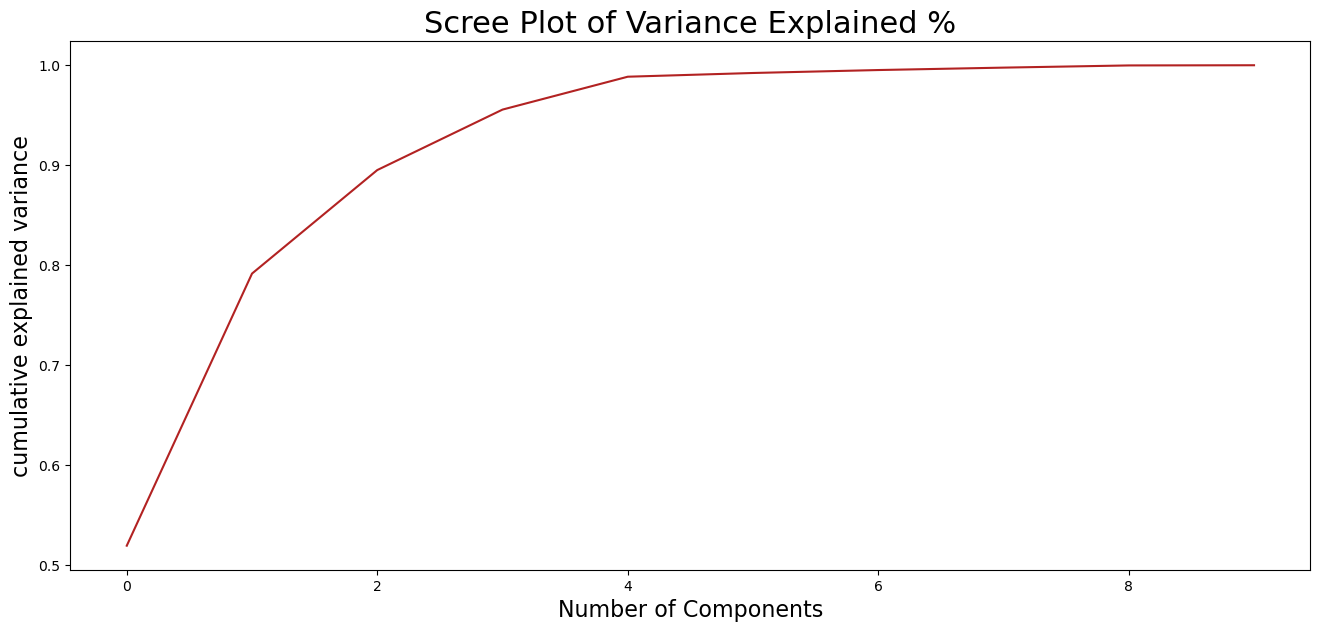

In [144]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum()
fig, axes = pyplot.subplots(1,1,figsize=(16,7), dpi=100)
pyplot.plot(variance_exp_cumsum, color='firebrick')
pyplot.title('Scree Plot of Variance Explained %', fontsize=22)
pyplot.xlabel('Number of Components', fontsize=16)
pyplot.ylabel('cumulative explained variance', fontsize=16)
pyplot.show()

In [119]:
NUMBER_OF_COMPONENTS = 2
print("Overall")
print(pca.explained_variance_ratio_)
for component in range(NUMBER_OF_COMPONENTS):
    comp = pca.components_[component]
    print("Component %i explains ratio: %.6f" % ((component + 1),pca.explained_variance_ratio_[component]) )
    sorted_index = np.argsort(comp)

Overall
[0.5251474  0.2682124  0.10504007 0.06082812 0.02904868 0.00389229
 0.00310605]
Component 1 explains ratio: 0.525147
Component 2 explains ratio: 0.268212


In [120]:
variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([52.499996, 79.299995, 89.799995, 95.899994, 98.799995, 99.2     ,
       99.5     ], dtype=float32)

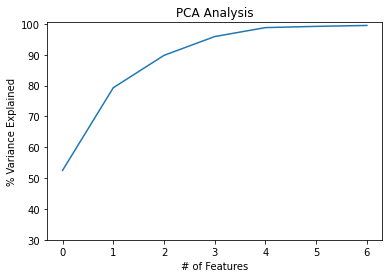

In [121]:
pyplot.ylabel('% Variance Explained')
pyplot.xlabel('# of Features')
pyplot.title('PCA Analysis')
pyplot.ylim(30,100.5)
pyplot.style.context('seaborn-whitegrid')

pyplot.plot(var)